# Lab 7 and 8

## Jennifer Vo, lab partners with William Olsen

### Lab 7: Event Selection Optimization

## Introduction and Selection

__You and your lab partner should pick different pT (transverse momentum) samples for this lab. In each pT sample, there are dedicated training samples for event selection optimization. All studies should be carried out by normalizing Higgs and QCD samples in each pT sample to give expected yields accordingly (See Dataset descriptions).__

In this lab, my partner and I will be optimizing the event selections in our LHC training samples. I will be working with the low PT training sample datasets, which come in two files: the QCD background dataset and the Higgs Boson signal dataset. There are 100k total events (jets) in each data set. The expected yield for the Higgs Boson signal data is 100 jets and the expected yield for QCD background data is 20,000 jets.

Since we will be altering the total number of data samples we are working with from 100k samples to some smaller value, the expected yields of both the signal and the background will decrease. In order to calculate this sensitivity, we will need to normalize each sample using the ratio of expected yields to the total data set size:

$$R_{qcd} = \frac{20000}{100000} = 0.2$$
$$R_{higgs} = \frac{100}{100000} = 0.001$$

Once I remove data from both sets and reduce the size of the total data set from $N_{initial} = 100000 \text{ to } N_{new}$, I can then calculate the expected yields of the qcd jets and signal jets using the ratios I calculated above:
$$yield_{qcd} = R_{qcd}*N_{new}$$
$$yield_{higgs} = R_{higgs}*N_{new}$$

In the previous labs (Lab 5), I identified the different variables which held discrimination power between the Higgs Boson signal data and the QCD background data. In this lab, I will be plotting more histograms to work through the optimization process comprehensively. 

First let's import the required libraries for this lab and load the files' datasets into arrays that I can work with.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import math
import pickle

#this sets the size of the plots to something useful
plt.rcParams["figure.figsize"] = (12,8)

In [2]:
# import library
import pickle

# open the qcd background data file, and use pickle loading
infile = open("qcd250-500.pkl",'rb')
qcd_dict = pickle.load(infile)

# open the higgs signal data file, and use pickle loading
infile = open("higgs250-500.pkl",'rb')
higgs_dict = pickle.load(infile)

## Part 1
First, I will be working with the variable "mass". This variable represents the sum of the masses of the jet's particles, produced in the collision. I would first like to create a stacked histogram plot for mass. In this case, I will create a stacked histogram by accessing the data from each file, creating a two-dimensional array with 100,000 rows and 2 columns, which contains the mass measurement from all jet events in both the background and the Higgs signal data. Once I plot this on the stacked histogram I will distinguish them by color.

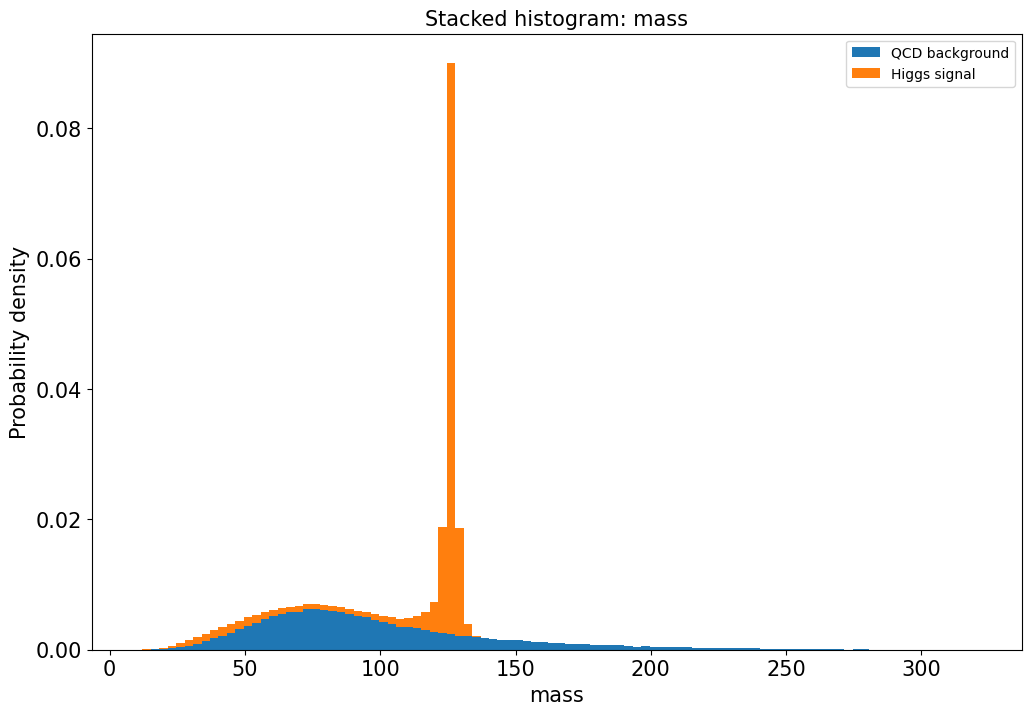

In [67]:
def plot_st_hist(var):
    w, h = 100000, 2
    combined = [[0 for x in range(w)] for y in range(h)]
    for i in range (0, 100000):
        combined[0][i] = qcd_dict[f'{var}'][i]
        combined[1][i] = higgs_dict[f'{var}'][i]

    plt.hist(combined, 100, density=True, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 15)
    plt.ylabel('Probability density', fontsize = 15)
    plt.title(f'Stacked histogram: {var}', fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

plot_st_hist('mass')

As we can see, the stacked histogram plot shows that the two datasets have a similar range of values, from 0 to around 270. However, it is clear that the Higgs signal has a much greater association with mass values around approximately 125 GeV.

Next I would like to evaluate the expected significance for this initial case without any event selection. I will assume that the QCD background particle events are Poisson-distributed because the event counts are discrete with very small probabilities of occurring. The expected yield for the Higgs Boson signal data is 100 jets and the expected yield for QCD background data is 20,000 jets. Thus a measurement that is most likely to come from a true Higgs boson signal (in this dataset) would be 20,100 jets = 20,000 + 100.

Therefore, to calculate the significance I will model for the QCD background a Poisson-distribution with the average parameter $\lambda$ = 20,000 jets, and a measurement of the Higgs signal being 20,100 jets. The question is thus: __"What would be the statistical significance for the background, a Poisson distribution with $\lambda$ = 20,000 to produce a signal of 20,100 or greater?"__

Intuitively, the significance level associated with this probability would be very low, too low to be considered as a physics discovery (which requires 5 sigma). Let us calculate this:

In [12]:
def calc_sigma_poisson(lam, signal):
    prob = stats.poisson.sf(signal, lam)
    sigma = stats.norm.isf(prob)
    
    return sigma
    
def calc_signal_poisson(lam, sigma):
    prob = stats.norm.sf(sigma)
    signal = stats.poisson.isf(prob, lam)
    
    return signal
    
sigma_base = calc_sigma_poisson(20000,20100)
print(f'The significance of the background QCD particles producing a measurement of 20,100 jets is {sigma_base:.4f} sigma.')

The significance of the background QCD particles producing a measurement of 20,100 jets is 0.7112 sigma.


As predicted, the significance of this is very low, not even 1 sigma.

Let us compare this significance to the approximation $N_{Higgs}/\sqrt{N_{QCD}}$. This approximation is calculated to be $100/\sqrt{20000} = 100/141.421 \text{which approximately = } 0.7071$. This is very close to what we obtained, 0.7112. They are approximately equal but not quite. I will now explain why this is:

First, one important property of the Poisson distribution is that for large values of $\lambda$, the Poisson distribution can be approximated by a Gaussian distribution. This means we can use Gaussian statistics as an approximation for the distribution. (?)

The other important property of the Poisson distribution is that both the expected value and the variance are equal to the parameter $\lambda$. Thus, for our QCD background distribution, the parameter $\lambda = 20,000$ implies a variance of 20,000 and a standard deviation of $\sqrt{20000} = 141.421$.

Putting these two facts together, we see that a deviation of 100 from the mean of the background distribution (20,000) would be $\frac{100}{141.421} \sigma$ or approximately $0.7071 \sigma$ away from the mean. (connect back to Gaussian stats property?)

## Part 2
[Identify mass cuts to optimize the expected significance.
- Try different mass cuts systematically
- Evaluate expected significance for each set of mass cuts
- Identify the set of mass cuts which give you the highest significance.]

Now that we have established the baseline significance I would like to optimize the expected significance by identifying first the best cut of the mass data. We saw that the Higgs signal is strongly associated with a mass around 125 GeV, but ranges between around 25 and 140 GeV. Therefore I will explore cuts around this value.

I will make cuts incrementally and compute the expected significance for each one, then determine which cut results in the highest significance.

To start, I will keep data between the range of 25 and 140 only, then narrow it down to smaller windows around 125 GeV.

In [97]:
def slice_data(qcd, higgs, var, low, high, toReturn):    
    # slice qcd
    ind_qcd_below = qcd[qcd[f'{var}'] < low].index
    ind_qcd_above = qcd[qcd[f'{var}'] > high].index
    new_qcd = qcd.drop(ind_qcd_below)
    new_qcd = new_qcd.drop(ind_qcd_above)
    
    # slice higgs
    ind_higgs_below = higgs[higgs[f'{var}'] < low].index
    ind_higgs_above = higgs[higgs[f'{var}'] > high].index
    new_higgs = higgs.drop(ind_higgs_below)
    new_higgs = new_higgs.drop(ind_higgs_above)
    
    # calc new expected yields of qcd and higgs
    R_qcd = 0.2
    R_higgs = 0.001
    y_qcd = int(R_qcd * len(new_qcd))
    y_higgs = int(R_higgs * len(new_higgs))
    
    #finally, calc new significance
    sigma = calc_sigma_poisson(y_qcd, y_qcd + y_higgs)
    
    if toReturn:
        return new_qcd, new_higgs, y_qcd, y_higgs, sigma
    else:
        return (f'Slicing data to keep range {low} to {high} GeV... The statistical significance of a yield of {y_higgs} jets is {sigma:.4f}')
    
# TODO: ASK ALEX ABOUT 'SYSTEMATICALLY' TRYING DIFFERENT MASS CUTS
# DO THIS ITERATION THROUGH FUNCTION OR IS MANUALLY OKAY?
print(slice_data(qcd_dict, higgs_dict, 'mass', 0, 300, False)) # check -> process is correct
print(slice_data(qcd_dict, higgs_dict, 'mass', 25, 140, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 115, 140, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, False))

Slicing data to keep range 0 to 300 GeV... The statistical significance of a yield of 100 jets is 0.7113
Slicing data to keep range 25 to 140 GeV... The statistical significance of a yield of 99 jets is 0.7668
Slicing data to keep range 115 to 140 GeV... The statistical significance of a yield of 81 jets is 1.6744
Slicing data to keep range 120 to 130 GeV... The statistical significance of a yield of 75 jets is 2.3870


As we can see the best cut corresponds to that between a low of 120 GeV and a high of 130 GeV, where we cut down from 100 jets to 75. This corresponds with a significance of 2.3870$\sigma$.

## Part 3
Make two sets of stacked histogram plots for the rest of the features
- Set A without any event selection
    - Can you identify another feature as discriminative as mass? (i.e. equal or better significance after feature cut)
- Set B with your optimal mass cuts
    - Can you identify another feature to further improve your expected signifiance?

In [98]:
# def function to plot stacked histograms before (set A) and after (set B) optimal mass cut
def plot_comparison(qcd, higgs, qcd_sliced, higgs_sliced, var):
    combined = [qcd[f'{var}'], higgs[f'{var}']]

    plt.subplot(2,1,1)
    plt.hist(combined, 100, density=True, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 15)
    plt.ylabel('Probability density', fontsize = 15)
    plt.title(f'Stacked histogram: {var}', fontsize = 15)
    
    combined_sliced = [qcd_sliced[f'{var}'], higgs_sliced[f'{var}']]
    
    plt.subplot(2,1,2)
    plt.hist(combined_sliced, 100, density=True, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 15)
    plt.ylabel('Probability density', fontsize = 15)
    plt.title(f'Stacked histogram: {var} with mass cut', fontsize = 15)

    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

output = slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, True)

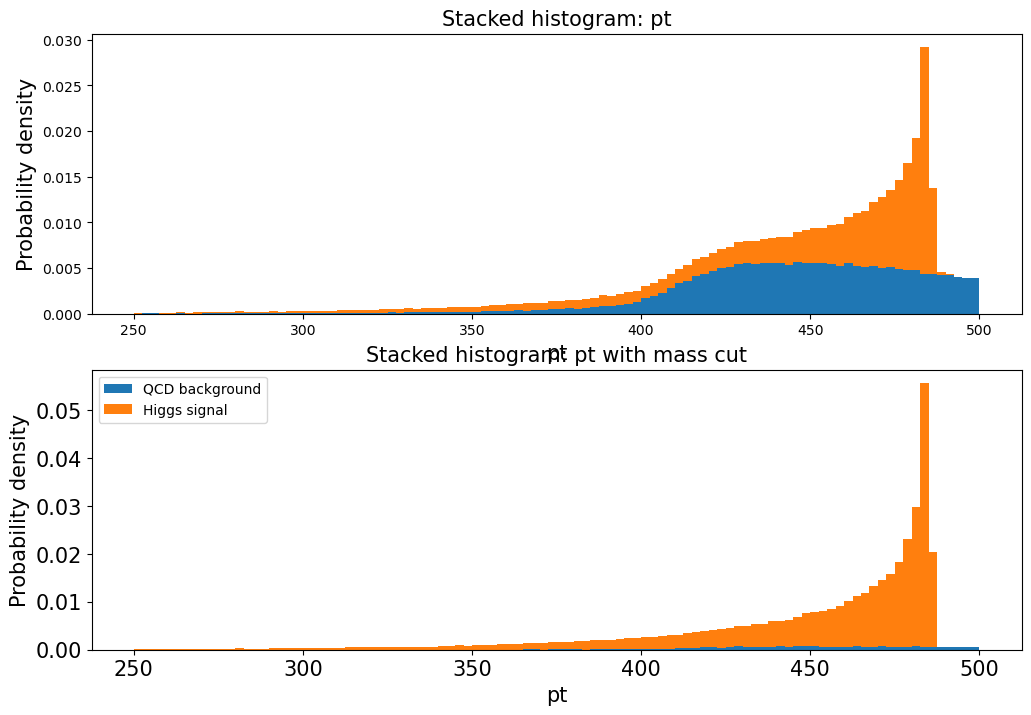

In [99]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'pt')

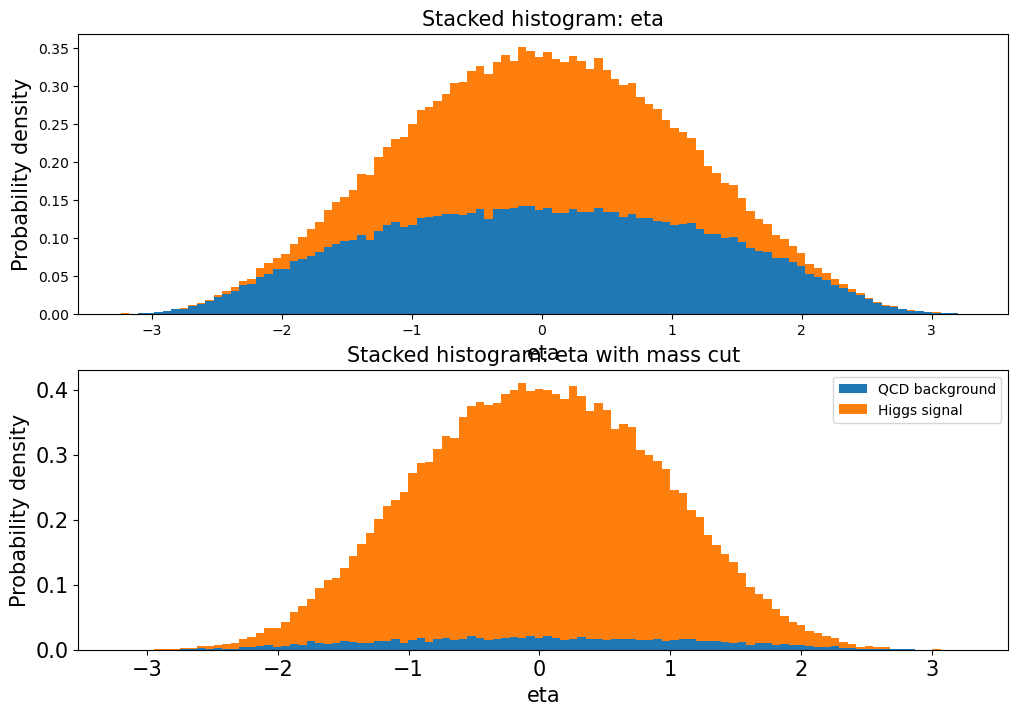

In [100]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'eta')

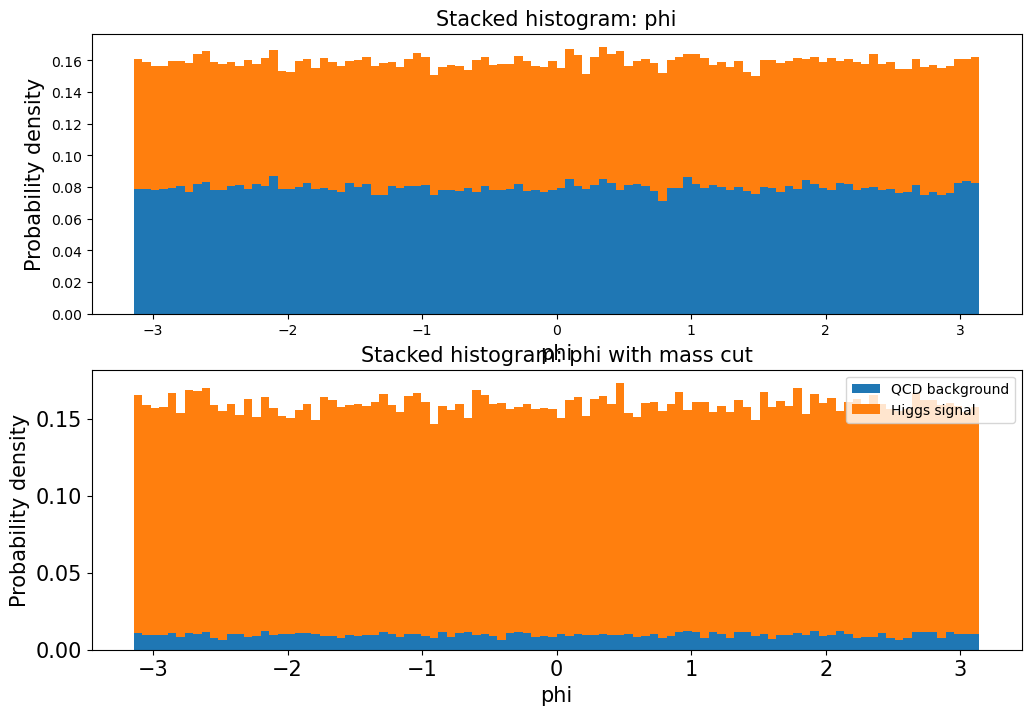

In [101]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'phi')

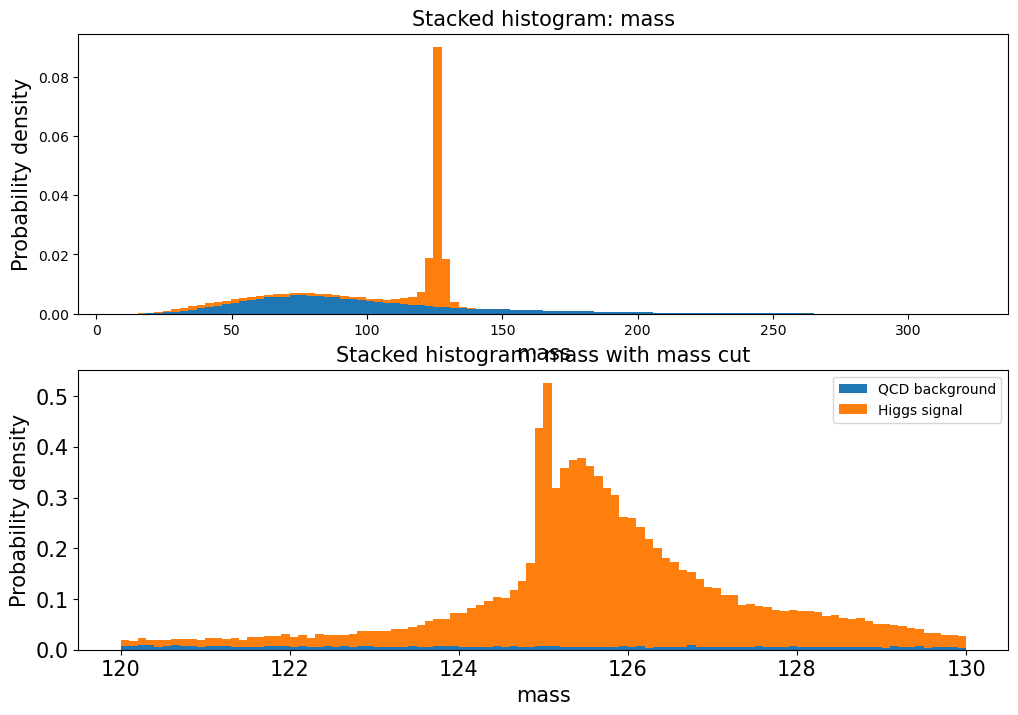

In [102]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'mass')

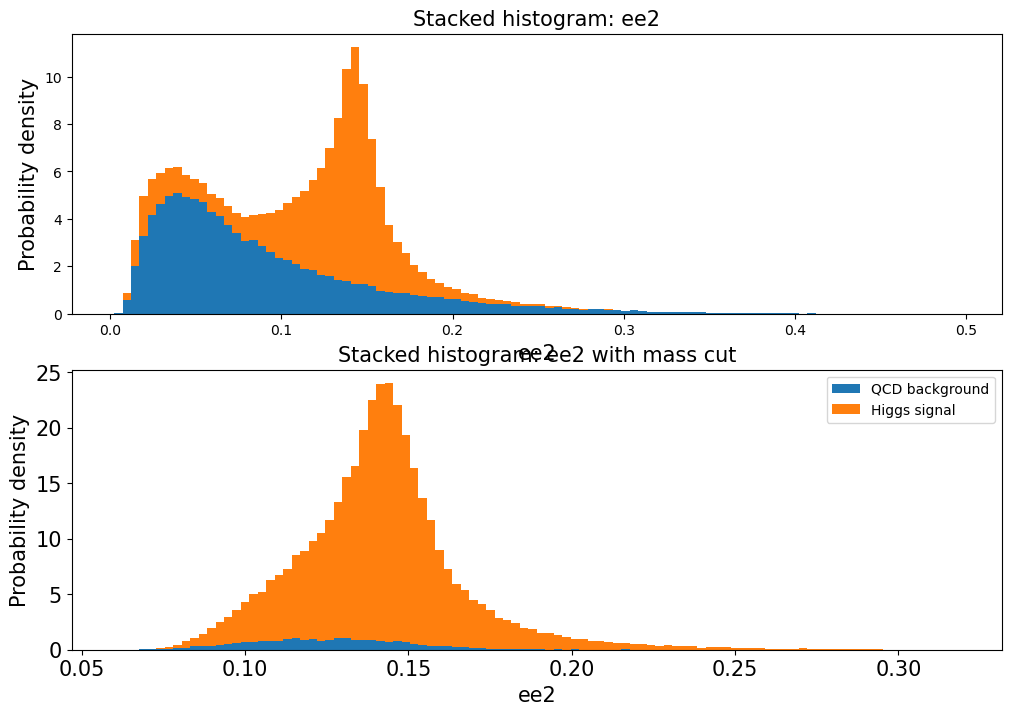

In [103]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'ee2')

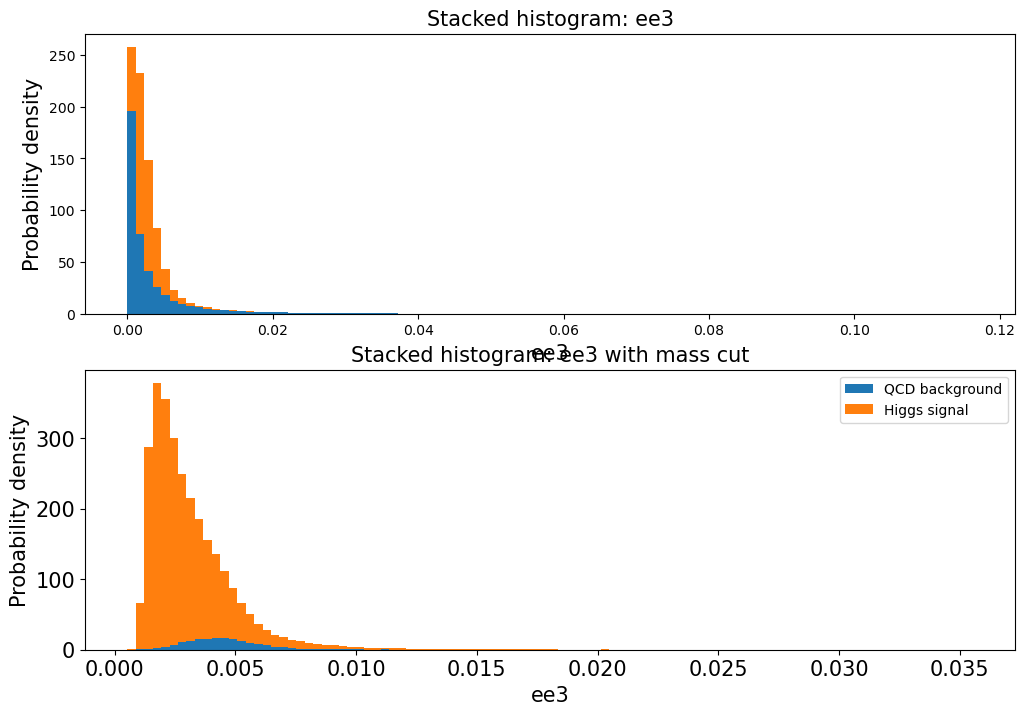

In [104]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'ee3')

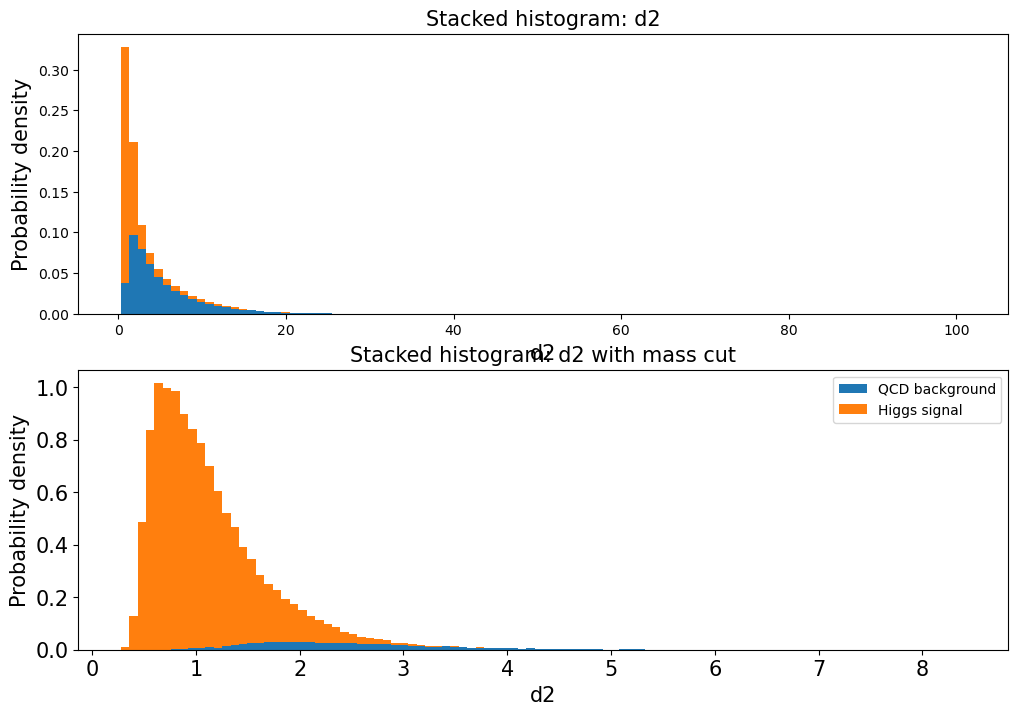

In [105]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'd2')

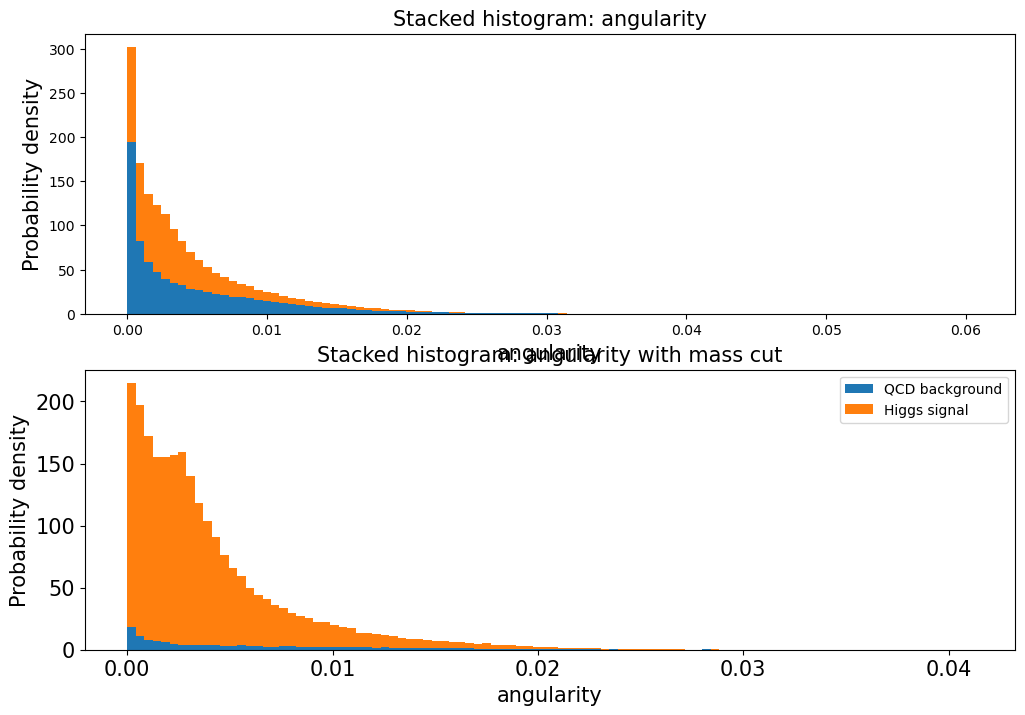

In [106]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'angularity')

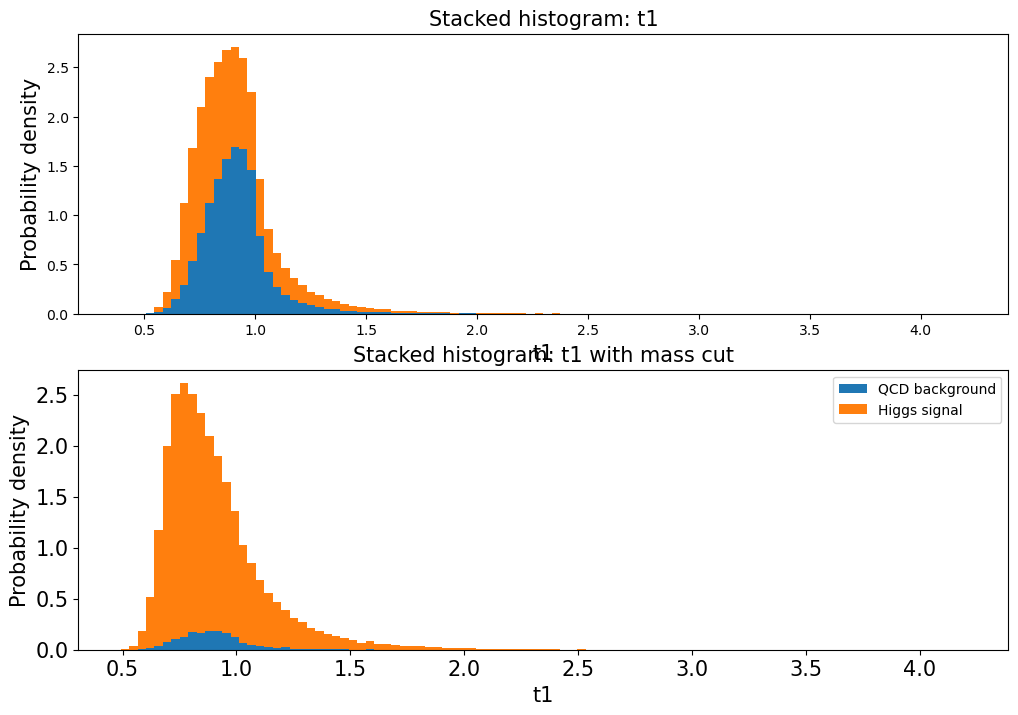

In [107]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't1')

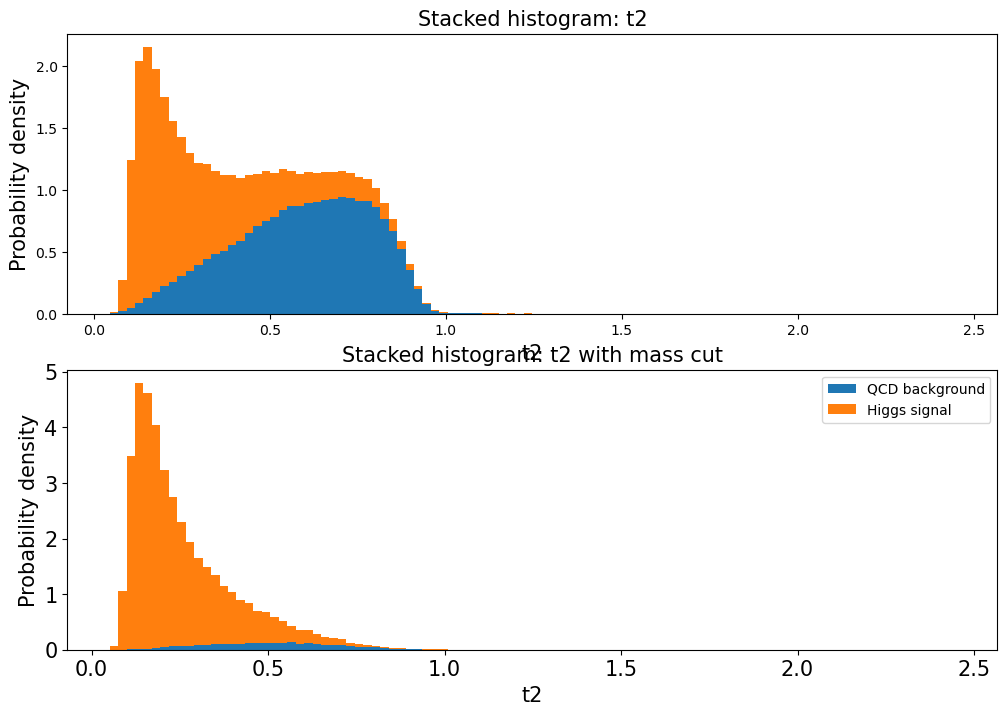

In [108]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't2')

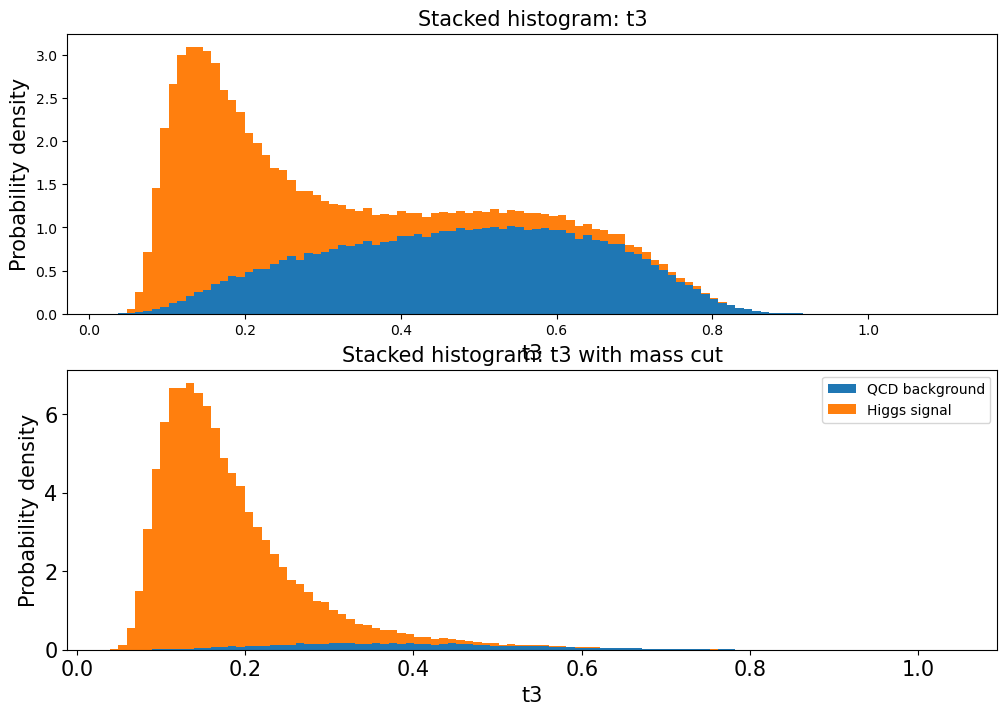

In [109]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't3')

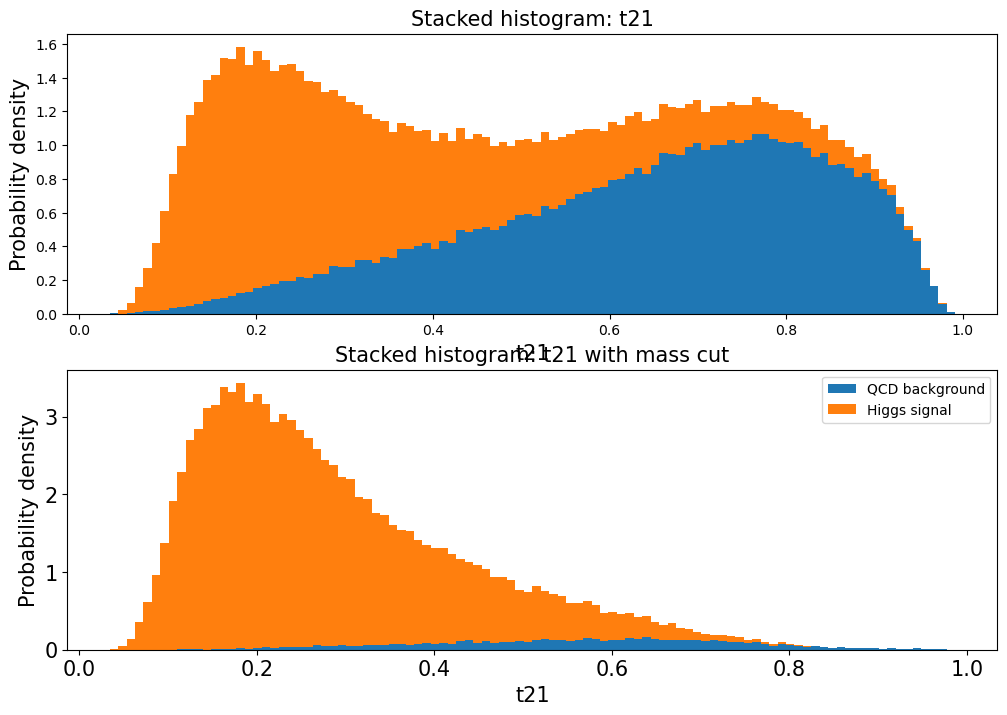

In [110]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't21')

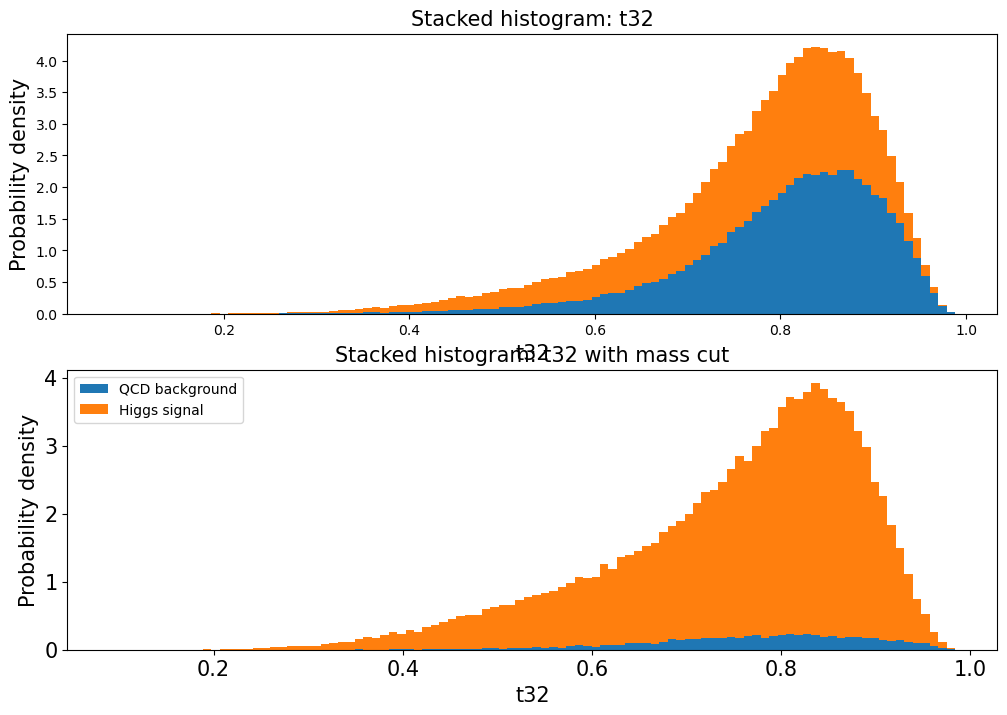

In [111]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't32')

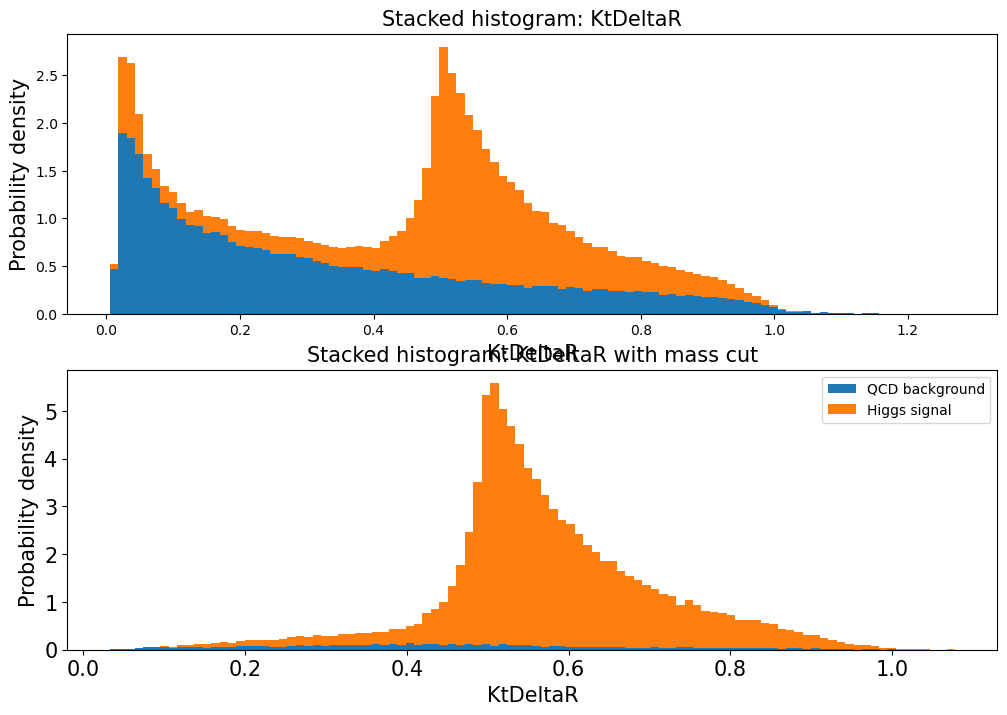

In [112]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'KtDeltaR')

## Part 4
Optimize event selections using multiple features (if necessary)
- Find a set of feature cuts which achieve high expected significance.
    - I will use t21 (assuming we can use different feature selections for this part)
- Compare significance (before/after event selection) derived in your pT samples to your lab partner. Describe your findings.


## Part 5
Bonus (optional):
- Plot 2-dimensional plots using the top two most discriminative features
    - Can you find a curve or a linear combination in this 2D plane which gives even better sensitivity? Extended reading: Lab 7 is a classificaition problem using multi-dimensional features in supervised machine learning. We can use popular machine learning tools to develop an optimial classifier which can maximize information by using all features. For interested students, you can read https://scikit-learn.org/stable/supervised_learning.html